# Module: Filter convolution

> Change from narrow-band SED to colors based on Telescope specification

In [ ]:
#| default_exp filter_convolution

In [ ]:
#| hide

from nbdev.showdoc import *

In [ ]:
#| export

import numpy as np
import glob
import pickle

import matplotlib.pylab as plt
from scipy.interpolate import interp1d as interp1d
from watercolor.ssp_interpolation import spec_ssp_lookup

from watercolor.load_sps_library import load_fsps_spectral_library, load_fsps_age_metallicity
from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE

from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.load_sim_stellar_catalog import GALS_FILE
from watercolor.load_sim_stellar_catalog import Z_SOLAR_PADOVA, H0

from watercolor.calculate_csp import calc_fluxes_for_galaxy
import pkg_resources

In [ ]:
#| hide

from matplotlib.cm import get_cmap

In [ ]:
#| hide

fof_halo_tag, if_satellite, gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()

In [ ]:
#| hide

gal_id = 4 #12
unique_gal_tag = np.unique(gal_tag)[gal_id]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(
    GALS_FILE, 
    unique_gal_tag,
    LIBRARY_FLUX_FILE,
    LIBRARY_WAVE_FILE,
    LIBRARY_AGE_FILE,
    LIBRARY_METAL_FILE)

(1.0, 10.0)

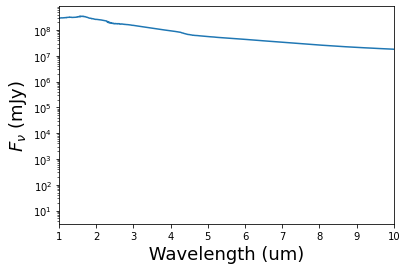

In [ ]:
#| hide

plt.figure()
# plt.plot(spec_wave_ssp/1e4, spec_flux_ssp.T*1e3)
plt.plot(spec_wave_ssp/1e4, spec_csp*1e3)
# plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$F_\nu$ (mJy)', fontsize=18)
plt.xlabel(' Wavelength (um) ', fontsize=18)
# plt.ylim(1e-3, 2e-1)
plt.xlim(1, 10)

In [ ]:
#| export

# ALL_FILTER_DIR = '../watercolor/data/filter_specifics/'
ALL_FILTER_DIR = "data/filter_specifics/"

FILTERS_LSST = pkg_resources.resource_stream("watercolor", ALL_FILTER_DIR + 'LSST.pickle').name
FILTERS_SPHEREX = pkg_resources.resource_stream("watercolor", ALL_FILTER_DIR + 'SPHEREx.pickle').name
FILTERS_COSMOS = pkg_resources.resource_stream("watercolor", ALL_FILTER_DIR + 'COSMOS.pickle').name

In [ ]:
#| export

def load_filter_single(filtfile:str=None, # Individual filter files 
                          norm:bool=True #Bandpass normalization condition
                         )->tuple: #Wavelengths, bandpass values, central wavelengths, filter name
    
    if ('SPHEREx' in filtfile):
        bandpass_name = filtfile.split('.dat')[0].split('/')[-1]
        x = np.loadtxt(filtfile)
    else:
        bandpass_name = filtfile.split('.npy')[0].split('/')[-1]
        x = np.load(filtfile)
    
    nonz = (x[:,1] != 0.)
    bandpass_wav = x[nonz,0]*1e-4
    bandpass_val = x[nonz,1]

    if norm:
        bandpass_val /= np.sum(bandpass_val)

    cenwav = np.dot(bandpass_wav, bandpass_val)
    # cenwav = np.dot(x[nonz,0], x[nonz,1])

    return bandpass_wav, bandpass_val, cenwav, bandpass_name

In [ ]:
#| export

def clip_bandpass_values(bandpass_wavs:np.float32=None, # Bandpass wavelengths
                       bandpass_vals:np.float32=None # Bandpasses
                      )->tuple: #Clipped bandpass wavelengths, clipped bandpass values
    
    all_clip_bandpass_wav, all_clip_bandpass_vals = [], []

    for b in range(len(bandpass_wavs)):
        nonz_bandpass_val = (bandpass_vals[b] > 0)
        clip_bandpass_wav = bandpass_wavs[b][nonz_bandpass_val]
        clip_bandpass_vals = bandpass_vals[b][nonz_bandpass_val]
        all_clip_bandpass_wav.append(clip_bandpass_wav)
        all_clip_bandpass_vals.append(clip_bandpass_vals)

    return all_clip_bandpass_wav, all_clip_bandpass_vals

In [ ]:
#| export 

def load_survey_filters(filtdir:str=ALL_FILTER_DIR+'LSST', #Input directory with all filter definitions
                        to_um:bool=True, #True/False to convert wavelengths to microns
                       )->tuple: #Central wavelengths, Bandpass wavelengths, Bandpass values, filter names 

    if ('SPHEREx' in filtdir):
        
        bandpass_wavs, bandpass_vals, central_wavelengths, bandpass_names = [], [], [], []
        
        bband_idxs = np.arange(1, 7)
    
        for bandidx in bband_idxs:
            # filtfiles = glob.glob(filtdir+'SPHEREx_band'+str(bandidx)+'*.dat')
            filtfiles = glob.glob(filtdir+'*'+str(bandidx)+'*.dat')

            for filtfile in filtfiles:

                bandpass_wav, bandpass_val, cenwav, bandpass_name = load_filter_single(filtfile)
                
                bandpass_names.append(bandpass_name)
                bandpass_wavs.append(bandpass_wav)
                bandpass_vals.append(bandpass_val)
                central_wavelengths.append(cenwav)
                
    
    else:
        bandpass_wavs, bandpass_vals, central_wavelengths, bandpass_names = [], [], [], []

        filtfiles = glob.glob(filtdir+'*.npy')
        for filtfile in filtfiles:            

            bandpass_wav, bandpass_val, cenwav, bandpass_name = load_filter_single(filtfile)
            
            
            bandpass_names.append(bandpass_name)
            bandpass_wavs.append(bandpass_wav)
            bandpass_vals.append(bandpass_val)
            central_wavelengths.append(cenwav)
        
        
    return central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names


In [ ]:
#| export

def load_survey_pickle(survey:str='LSST' #Survey
                      )->tuple: #Central wavelengths, Bandpass wavelengths, Bandpass values, filter names
    
    if (survey=='LSST'):
        FILTER_NAME = FILTERS_LSST
    elif (survey=='SPHEREx'):
        FILTER_NAME = FILTERS_SPHEREX
    elif (survey=='COSMOS'):
        FILTER_NAME = FILTERS_COSMOS
    else: 
        raise NotImplementedError("Filter specifications not included")
        
    with open(FILTER_NAME, 'rb') as f:
     central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = pickle.load(f)
    
    return central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names

In [ ]:
#| export

def photometry_from_spectra(central_wavelengths:np.array=None, # Central wavelengths
                     sed_um_wave:np.array=None, # SED wavelengths (in microns)
                     sed_mJy_flux:np.array=None, # SED fluxes (in mJy)
                     bandpass_wavs:np.array=None, # Bandpass wavelenths
                     bandpass_vals:np.array=None, # Bandspass values
                     bandpass_names:np.array=None, #Names of the bandpasses
                     interp_kind:str='linear', # Interpolation type
                     plot:bool=True, # Plotting SEDs with filter convolution
                     clip_bandpass:bool=True #Clip bandpass condition
                    )->tuple: # Fluxes, Apparent magnitudes, Band fluxes
    # central wavelengths in micron
    if clip_bandpass:
        all_clip_bandpass_wav, all_clip_bandpass_vals =  clip_bandpass_values(bandpass_wavs, bandpass_vals)

    sed_interp = interp1d(sed_um_wave,
                          sed_mJy_flux,
                          kind=interp_kind,
                          bounds_error=False, 
                          fill_value = 0.0)

    band_fluxes = np.zeros_like(central_wavelengths)

    for b, bandpass_wav in enumerate(bandpass_wavs):
        # fluxes in mJy
        if clip_bandpass:
            band_fluxes[b] = np.dot(all_clip_bandpass_vals[b], sed_interp(all_clip_bandpass_wav[b]))
        else:
            band_fluxes[b] = np.dot(bandpass_vals[b], sed_interp(bandpass_wav))

    flux = 1e3*band_fluxes # uJy
    appmag_ext = -2.5*np.log10(flux)+23.9

    if plot:

        wav_um = np.array(central_wavelengths)

        # plt.figure(figsize=(12, 4))
        f, a = plt.subplots(2, 1, figsize=(14, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
        a[0].set_title('sed uJy flux')
        a[0].plot(sed_um_wave, 1e3*sed_mJy_flux, color='k', zorder=5, alpha=0.5)
        a[0].scatter(wav_um, flux, color='r', label='bandpass-convolved fluxes', s=30)
        # plt.ylim(0, 1.2*np.max(flux))
        a[0].set_ylabel('uJy', fontsize=16)
        a[0].set_xlim(wav_um.min()*0.8, wav_um.max()*1.2)
        # plt.tick_params(labelsize=14)
        # plt.legend()
        
        
        a[1].set_title('Filter transmissions')
        for central_idx in range(wav_um.shape[0]):
            a[1].plot(bandpass_wavs[central_idx], bandpass_vals[central_idx], label=bandpass_names[central_idx])
        
        a[1].set_xlabel('um', fontsize=16)
        plt.show()

    return flux, appmag_ext, band_fluxes

In [ ]:
#hide 

write_pickle = False 

if write_pickle:

    #### Converting numerious filter spec files to pickle files. To keep package loading simple

    ####
    raw_filter_specs_dir = '/lcrc/project/cosmo_ai/nramachandra/Projects/Hydro_paint/filter_specifics/'
    survey_filter_structure = load_survey_filters(filtdir=raw_filter_specs_dir+'LSST', to_um=True)
    out_filter_pickle = '../watercolor/data/filter_specifics/'


    with open( out_filter_pickle + 'LSST' + '.pickle', 'wb') as f:
        pickle.dump(survey_filter_structure, f)


    #### 
    survey_filter_structure = load_survey_filters(filtdir=raw_filter_specs_dir+'cosmos', to_um=True)

    with open( out_filter_pickle + 'COSMOS' + '.pickle', 'wb') as f:
        pickle.dump(survey_filter_structure, f)


    ####
    survey_filter_structure = load_survey_filters(filtdir=raw_filter_specs_dir+'SPHEREx', to_um=True)

    with open( out_filter_pickle + 'SPHEREx' + '.pickle', 'wb') as f:
        pickle.dump(survey_filter_structure, f)

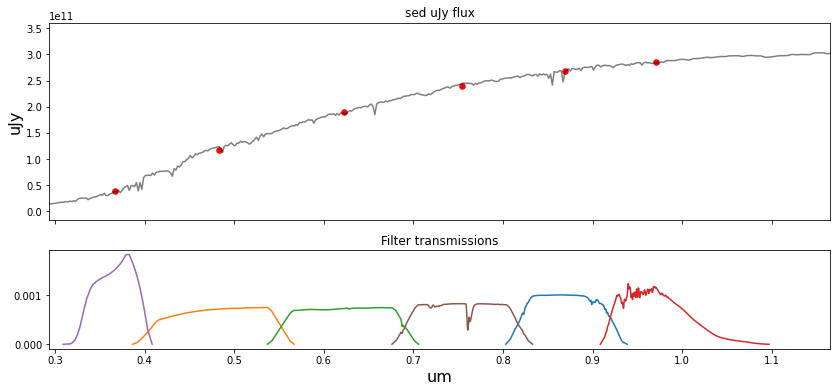

In [ ]:
#| hide

##### Load survey filters 


SURVEY_STRING = 'LSST'

# central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_filters(filtdir=ALL_FILTER_DIR+SURVEY_STRING, to_um=True)
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle(SURVEY_STRING)

##### Compute bandpasses

sed_um_wave = spec_wave_ssp/1e4
sed_mJy_flux = spec_csp*1e3

flux_survey, appmag_ext_survey, band_fluxes_survey = photometry_from_spectra(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals,
                                                                          bandpass_names,
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

In [ ]:
band_fluxes_survey

array([2.67464624e+08, 1.16847656e+08, 1.89048992e+08, 2.85284384e+08,
       3.82984400e+07, 2.39753040e+08], dtype=float32)

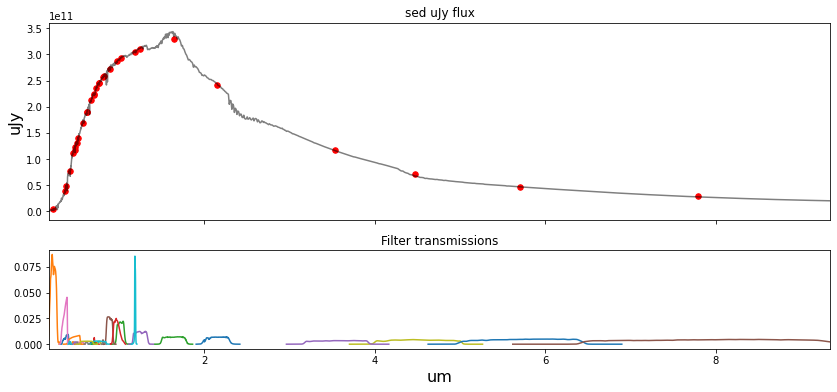

In [ ]:
#| hide

##### Load survey filters 

SURVEY_STRING = 'COSMOS'
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle(SURVEY_STRING)

##### Compute bandpasses

sed_um_wave = spec_wave_ssp/1e4
sed_mJy_flux = spec_csp*1e3

flux_survey, appmag_ext_survey, band_fluxes_survey = photometry_from_spectra(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals,
                                                                          bandpass_names,
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

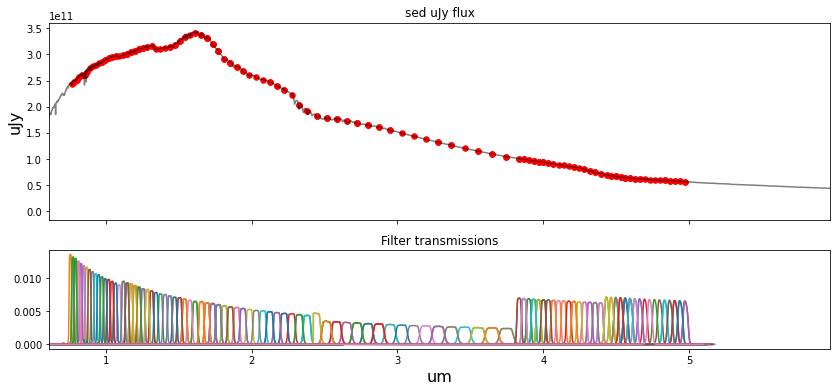

In [ ]:
#| hide

##### Load survey filters 

SURVEY_STRING = 'SPHEREx'
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle(SURVEY_STRING)

##### Compute bandpasses

sed_um_wave = spec_wave_ssp/1e4
sed_mJy_flux = spec_csp*1e3

flux_survey, appmag_ext_survey, band_fluxes_survey = photometry_from_spectra(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals, 
                                                                          bandpass_names,
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

In [ ]:
#| hide

import nbdev; nbdev.nbdev_export()